<a href="https://colab.research.google.com/github/MagicMoleMM/Machine_learning_LSTM/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22LSTM_Weekly%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch



## Download Dataset

In [1]:
import requests
import csv
import seaborn as sns

## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

Функция получения данных AV

In [3]:
def get_fx_weekly(from_symbol, to_symbol, apikey):

    url = f'https://www.alphavantage.co/query?function=FX_WEEKLY&from_symbol={from_symbol}&to_symbol={to_symbol}&datatype=csv&apikey={apikey}'

    r = requests.get(url)
    decoded_content = r.content.decode('utf-8')
    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    dt = pd.DataFrame(data)
    dt.columns = ['timestamp','open', 'high', 'low', 'close']
    dt = dt.iloc[1:]
    dt = dt.set_index('timestamp', inplace=False)

    return dt

Получение данных AV

In [21]:
from_symbol = 'EUR'
to_symbol = 'USD'
# interval = '60min'  # 1min, 5min, 15min, 30min, 60min
outputsize = 'full'  # Optional compact or full
apikey = '2GGORTBXQIFSR2AF'

#  Загружаем данные


data_1w_load = get_fx_weekly(from_symbol, to_symbol, apikey).iloc[::-1]

Загрузка в формате csv


In [22]:
print(data_1w_load)

               open     high      low    close
timestamp                                     
2003-05-30  1.18230  1.19290  1.16880  1.17860
2003-06-06  1.17060  1.18880  1.16250  1.16980
2003-06-13  1.17060  1.18790  1.16500  1.18700
2003-06-20  1.18700  1.19280  1.15490  1.15830
2003-06-27  1.15940  1.16230  1.13970  1.14180
...             ...      ...      ...      ...
2022-06-17  1.05142  1.06014  1.03570  1.04980
2022-06-24  1.04870  1.06059  1.04670  1.05540
2022-07-01  1.05525  1.06150  1.03650  1.04280
2022-07-08  1.04206  1.04628  1.00710  1.01830
2022-07-15  1.01791  1.01834  0.99500  1.00843

[999 rows x 4 columns]



DataFrame

In [23]:
training_set_1 = pd.DataFrame(data_1w_load)
training_set_1

,open,high,low,close
timestamp,,,,
2003-05-30,1.18230,1.19290,1.16880,1.17860
2003-06-06,1.17060,1.18880,1.16250,1.16980
2003-06-13,1.17060,1.18790,1.16500,1.18700
2003-06-20,1.18700,1.19280,1.15490,1.15830
2003-06-27,1.15940,1.16230,1.13970,1.14180
...,...,...,...,...
2022-06-17,1.05142,1.06014,1.03570,1.04980
2022-06-24,1.04870,1.06059,1.04670,1.05540
2022-07-01,1.05525,1.06150,1.03650,1.04280


 Цены закрытия

In [24]:
price_close = training_set_1.close
pd.to_datetime(price_close.index)
pd.to_numeric(price_close.values)
price_close

timestamp
2003-05-30    1.17860
2003-06-06    1.16980
2003-06-13    1.18700
2003-06-20    1.15830
2003-06-27    1.14180
               ...   
2022-06-17    1.04980
2022-06-24    1.05540
2022-07-01    1.04280
2022-07-08    1.01830
2022-07-15    1.00843
Name: close, Length: 999, dtype: object

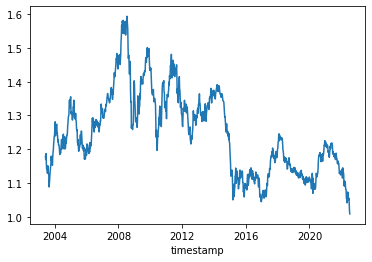

In [25]:
training_set = price_close
g=sns.lineplot(y=pd.to_numeric(training_set.values), x=pd.to_datetime(training_set.index), data=training_set)


In [26]:
print(training_set)
print(len(training_set))

timestamp
2003-05-30    1.17860
2003-06-06    1.16980
2003-06-13    1.18700
2003-06-20    1.15830
2003-06-27    1.14180
               ...   
2022-06-17    1.04980
2022-06-24    1.05540
2022-07-01    1.04280
2022-07-08    1.01830
2022-07-15    1.00843
Name: close, Length: 999, dtype: object
999


## Dataloading

In [28]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_ = np.array(training_set[:900]).reshape(-1, 1)
training_data = sc.fit_transform(training_)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))

# trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
# trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
# testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


data_set = np.array(training_set[900:]).reshape(-1, 1)
data_data = sc.transform(data_set)

seq_length = 4
a, b = sliding_windows(data_data, seq_length)

dataX = Variable(torch.Tensor(np.array(a)))
dataY = Variable(torch.Tensor(np.array(b)))


In [30]:
print(len(training_set[900:]))
print(len(training_))


99
900


## Model

In [31]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [32]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 10
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.28826
Epoch: 100, loss: 0.00163
Epoch: 200, loss: 0.00152
Epoch: 300, loss: 0.00140
Epoch: 400, loss: 0.00128
Epoch: 500, loss: 0.00116
Epoch: 600, loss: 0.00104
Epoch: 700, loss: 0.00098
Epoch: 800, loss: 0.00096
Epoch: 900, loss: 0.00095
Epoch: 1000, loss: 0.00094
Epoch: 1100, loss: 0.00093
Epoch: 1200, loss: 0.00093
Epoch: 1300, loss: 0.00093
Epoch: 1400, loss: 0.00092
Epoch: 1500, loss: 0.00092
Epoch: 1600, loss: 0.00092
Epoch: 1700, loss: 0.00092
Epoch: 1800, loss: 0.00092
Epoch: 1900, loss: 0.00092


## Testing 

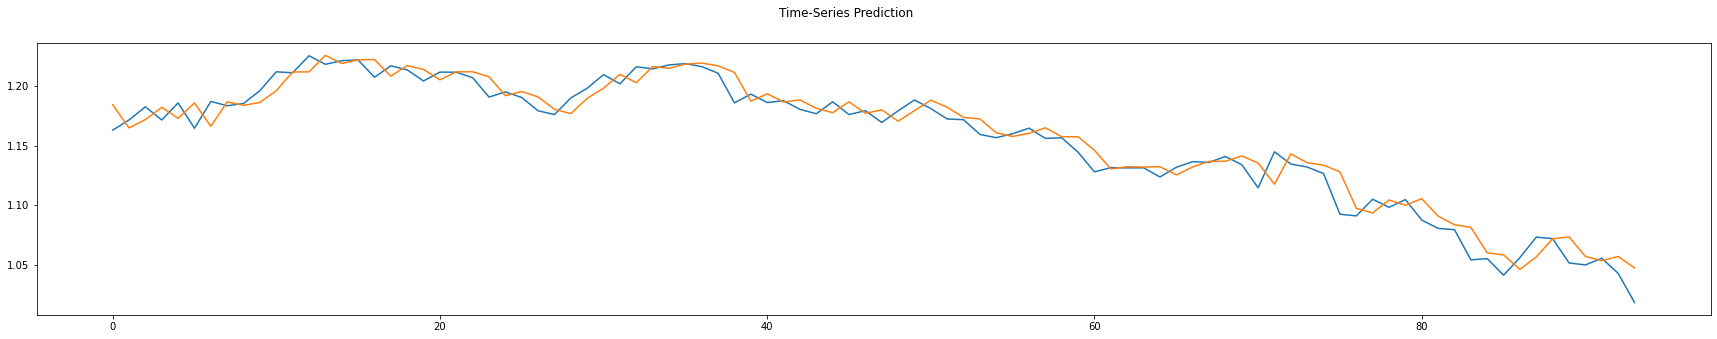

In [33]:
lstm.eval()
# train_predict = lstm(trainX)
train_predict_test = lstm(dataX)

# data_predict1 = train_predict.data.numpy()
data_predict1_test = train_predict_test.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict1)
data_predict_test = sc.inverse_transform(data_predict1_test)
dataY_plot = sc.inverse_transform(dataY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(30, 5))
plt.plot(dataY_plot)
# plt.plot(data_predict)
plt.plot(data_predict_test)
plt.suptitle('Time-Series Prediction')
plt.show()

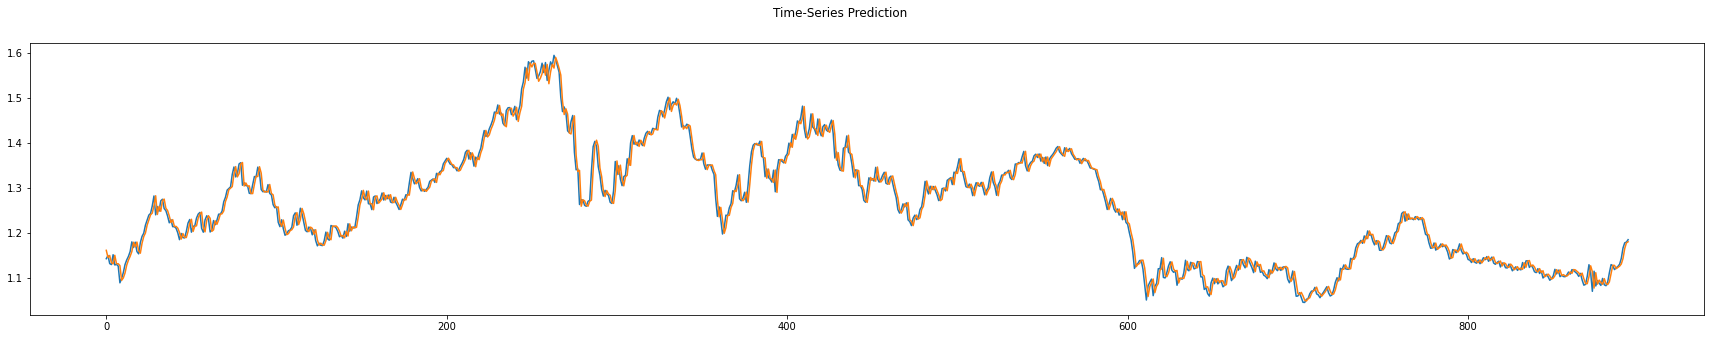

In [34]:
lstm.eval()
train_predict = lstm(trainX)
data_predict1 = train_predict.data.numpy()
trainY_plot = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict1)
trainY_plot = sc.inverse_transform(trainY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(30, 5))
plt.plot(trainY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()


